In [1]:
import numpy as np
from scipy.stats import laplace
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
from math import prod

%matplotlib inline

In [2]:
#Inputs:

#Conditioning variable X_data and corresponding response Y_data
#alpha_range: the acceptable range for the alpha parameters. This defaults to [0,1], 
#             which allows for positive association only. Change to [-1,1] to allow for both positive and negative.
#use_DL: boolean to determine whether Delta Laplace margins are incorporated. See Wadsworth and Tawn (2019). Currently not accepted


def CondExtBivNegLogLik(x, X_data, Y_data, use_DL=True,alpha_range = [0,1]):

    
    if use_DL == False:
        
        alpha, beta, mu, sigma = x
        
    else:
        
        alpha, beta, mu, sigma,delta = x

        
    if not alpha_range[0] <= alpha <= alpha_range[1]:
        
        return(1e10)
    
    if sigma <= 0:
        
        return(1e10)
    
    dist = norm(loc = mu, scale = sigma)
    
    Z = (Y_data - alpha * X_data)/ X_data** beta
    
    return( - sum(np.log(dist.pdf(Z)/X_data**beta)))


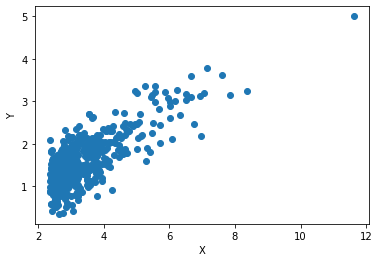

In [3]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(10000)

#We'll also let Z be Gaussian noise, albeit not standard

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X = X[X>u]
Z = np.random.normal(loc = 0.2,scale = 0.3,size=len(X))

Y = 0.4 * X + Z*(X**0.2)


fig=plt.figure()
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [8]:
## Fit distribution.

init_par=np.random.rand(4)

X_data, Y_data = X,Y

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par, args=(X_data,Y_data,False,[0,1]),
               method="Nelder-Mead")
fit

 final_simplex: (array([[0.42618717, 0.27478303, 0.11949216, 0.28197068],
       [0.42618541, 0.27486625, 0.11948258, 0.28194758],
       [0.42619054, 0.2747376 , 0.11947942, 0.2819941 ],
       [0.42620504, 0.27480914, 0.11945291, 0.28197031],
       [0.42619782, 0.27477941, 0.11946704, 0.28196873]]), array([239.06119367, 239.06119371, 239.06119372, 239.06119407,
       239.06119416]))
           fun: 239.06119367122423
       message: 'Optimization terminated successfully.'
          nfev: 511
           nit: 302
        status: 0
       success: True
             x: array([0.42618717, 0.27478303, 0.11949216, 0.28197068])

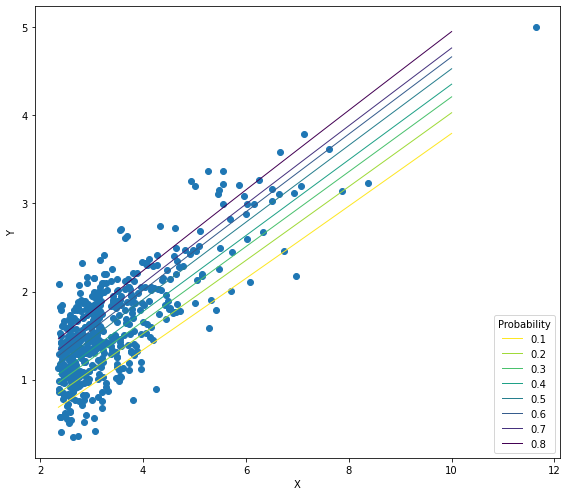

In [11]:
# Overlay conditional quantiles, given X > u, on Scatter plot
alpha,beta,mu,sigma = fit.x

x_seq=np.linspace(u,10,100)
probs=np.arange(0.1,0.9,0.1)

# We will estimate quantiles from the data. Quantiles from the parametric distributions can alsso be used.
z_hat = (Y - alpha * X)/ X** beta

quants = np.quantile(z_hat, probs)

plt.figure(figsize=(8,7))
plt.scatter(X,Y)
viridis = cm.get_cmap('viridis', len(probs))
for k in range(0,len(probs)):
    
    plt.plot(x_seq,alpha*x_seq+quants[k]*x_seq**beta,color = viridis.colors[-(k+1)], linewidth = 1)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend( np.around(probs,2), loc = 4, title = "Probability")
plt.tight_layout()
plt.show()